## Concurrency HW3
### Иван Старостин, М05-014в

Самым нетривиальным моментом в моделировании протокола TokenRing является эмуляция работы сети. Каналы связи между узлами можно представить thread safe очередямя, их потребуется N штук. В качестве baseline возьмем стандартную java.util.concurrent.ConcurrentLinkedQueue (реализация очереди МайклаСкотта, wait free). Каждый узел поток будет в цикле пытаться читать сообщения из входного канала, поглощать адресованные ему, а остальные переправлять в исходящий канал. Кроме того, на каждом шаге поток будет с некоторой вероятностью генерировать сообщение случайному адресату. Т.к. протокол предполагает бесконечную работу, будем отключать модель после фиксированного времени (10 сек) <br>
Для измерения целевых характеристик (latency и throughput) будем при каждой отправке и получении сообщения сохранять метрики о системе с помощью класса Logger. Пропускную способность можно по определению представить как $$throughput = \frac{totalMessagesReceived}{runtime}$$ Время работы фиксированно, а количество полученных сообщений считаем с помощью атомарного счетчика. Для подсчета latency заведем в каждом сообщении timestamp отправки и получения, разницы которых и составляет задержку. Заметим, что средняя задержка $$E(latency)=\frac{\sum_{i=0}^{totalMessagesReceived}{(treceived_i - tsent_i)}}{totalMessagesReceived} = \frac{\sum_{i=0}^{totalMessagesReceived}{treceived_i} - \sum_{i=0}^{totalMessagesReceived}{tsent_i}}{totalMessagesReceived}$$
Следовательно, для ее подсчета достаточно сохранить сумму временных меток отправки и получения по всем сообщениям, что значительно упрощает процедуру логгирования. Для расчета среднего количества пакетов, одновременно находящихся в процессе доставки, будем аналогично предыдущему пункту хранить комулятивную сумму значений totalMessagesSent и totalMessagesReceived и обновлять ее при каждом получении и отправке сообщения, а в конце разделить их разницу на количество записей. <br>
По итогам моделирования имеем записи по четырем величинам: количество узлов N, среднее количество пакетов, одновременно находящихся в пересылке inTransfer, пропускную способность throughput и среднюю задержку latency. Величину throughput нормируем по количеству узлов, т.к. каждый из них генерирует сообщения с одинаковой частотой независимо от других. Построим попарные гафики зависимости throughput и latency от N и inTransfer, а также отобразим характер зависимостей одновременно от двух переменных с помощью heatmap.

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np

In [2]:
data = pd.read_csv('benchmark_baseline.csv', header = 0, names = ['N', 'inTransfer', 'throughput', 'latency'])
data['throughput'] = data['throughput']/data['N']

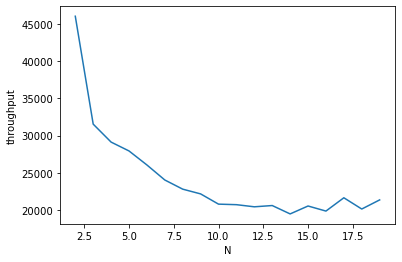

In [3]:
sb.lineplot(data=data[['N', 'throughput']], x='N', y='throughput', sort=True, ci=None)

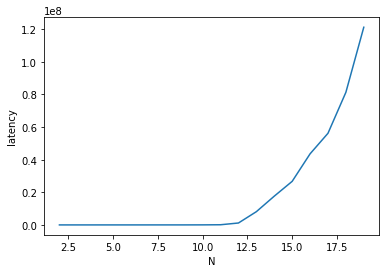

In [4]:
sb.lineplot(data=data[['N', 'latency']], x='N', y='latency', sort=True, ci=None)

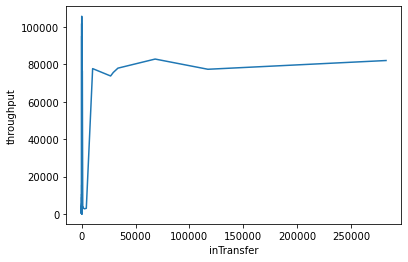

In [5]:
sb.lineplot(data=data[['inTransfer', 'throughput']], x='inTransfer', y='throughput', sort=True, ci=None)

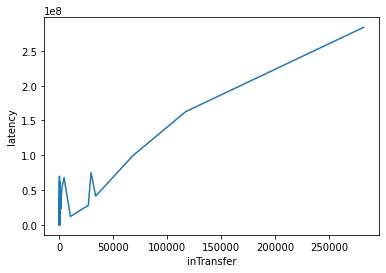

In [6]:
sb.lineplot(data=data[['inTransfer', 'latency']], x='inTransfer', y='latency', sort=True, ci=None)

In [7]:
from matplotlib.colors import LogNorm

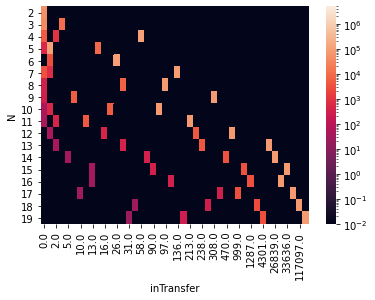

In [8]:
df = data[['N', 'inTransfer', 'throughput']].round().reset_index().pivot_table(index='N', columns='inTransfer', values='throughput').fillna(0.01)
sb.heatmap(df, norm=LogNorm(vmin=0.01, vmax=5e6), vmin=0.01, vmax=5e6)

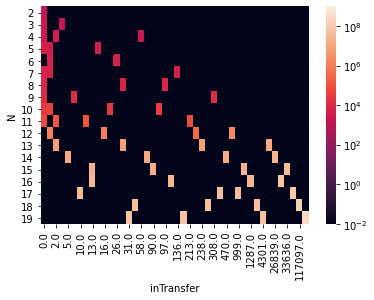

In [9]:
df = data[['N', 'inTransfer', 'latency']].round().reset_index().pivot_table(index='N', columns='inTransfer', values='latency').fillna(0.01)
sb.heatmap(df, norm=LogNorm(vmin=0.01, vmax=1e9), vmin=0.01, vmax=1e9)

### Выводы
Как и следовало ожидать, эффективность работы сети стремительно падает при увеличении нагрузки. Значение latency начинает стремительно расти при N > 12, что можно объяснить появлением интервалов ожидания при пересылке сообщений, т.к. тестирование производится на устройстве с 12 виртуальными ядрами. Интересно заметить, что при росте inTransfer значение throughput стабилизируется на постоянной величине, из чего можно предположить существование для рассматриваемой модели примерной максимальной пропускной способности, которая не зависит от количества пакетов в очереди и достигается при стабилизации. Кроме того, latency практически линейно зависит от inTransfer, что также ожидаемо, т.к. каждому сообщению приходится перед каждой пересылкой стоять в очереди период времени, пропорциональный количеству сообщений перед ним, которое в среднем за время работы равно $\frac{inTransfer}{N}$ <br>
### Оптимизация реализации
Для оптимизации модели попробуем заменить стандартную очередь общего вида java.util.concurrent.ConcurrentLinkedQueue на single producer single consumer очереди из библиотеки jctools. Будем использовать SpscLinkedAtomicQueue и SpscLinkedQueue (обе wait-free), для каждой из полученных моделей запустим тесты с аналогичными параметрами и построим аналогичные графики

In [10]:
data = pd.read_csv('benchmark_1.csv', header = 0, names = ['N', 'inTransfer', 'throughput', 'latency'])
data['throughput'] = data['throughput']/data['N']

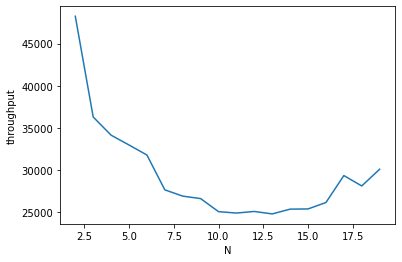

In [11]:
sb.lineplot(data=data[['N', 'throughput']], x='N', y='throughput', sort=True, ci=None)

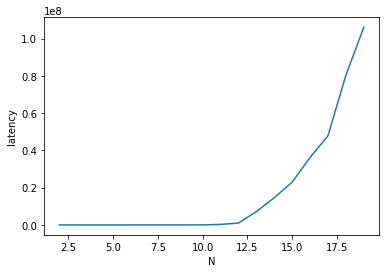

In [12]:
sb.lineplot(data=data[['N', 'latency']], x='N', y='latency', sort=True, ci=None)

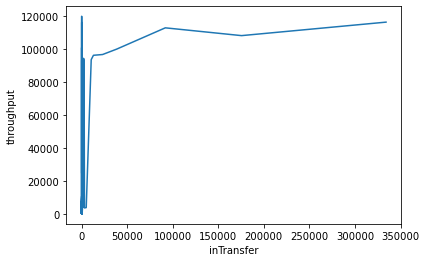

In [13]:
sb.lineplot(data=data[['inTransfer', 'throughput']], x='inTransfer', y='throughput', sort=True, ci=None)

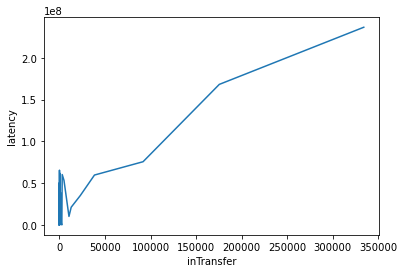

In [14]:
sb.lineplot(data=data[['inTransfer', 'latency']], x='inTransfer', y='latency', sort=True, ci=None)

In [15]:
from matplotlib.colors import LogNorm

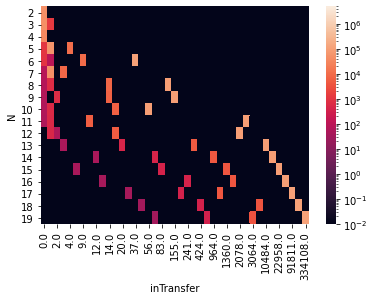

In [16]:
df = data[['N', 'inTransfer', 'throughput']].round().reset_index().pivot_table(index='N', columns='inTransfer', values='throughput').fillna(0.01)
sb.heatmap(df, norm=LogNorm(vmin=0.01, vmax=5e6), vmin=0.01, vmax=5e6)

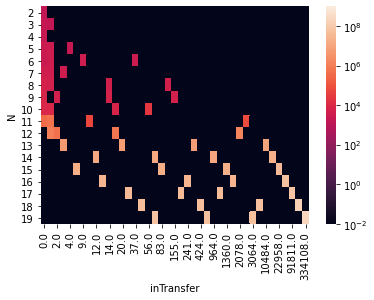

In [17]:
df = data[['N', 'inTransfer', 'latency']].round().reset_index().pivot_table(index='N', columns='inTransfer', values='latency').fillna(0.01)
sb.heatmap(df, norm=LogNorm(vmin=0.01, vmax=1e9), vmin=0.01, vmax=1e9)

In [18]:
data = pd.read_csv('benchmark_2.csv', header = 0, names = ['N', 'inTransfer', 'throughput', 'latency'])
data['throughput'] = data['throughput']/data['N']

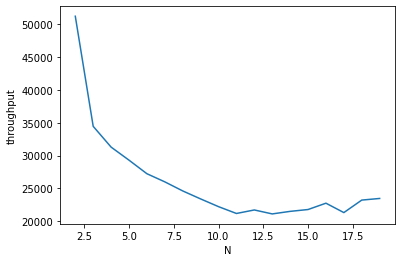

In [19]:
sb.lineplot(data=data[['N', 'throughput']], x='N', y='throughput', sort=True, ci=None)

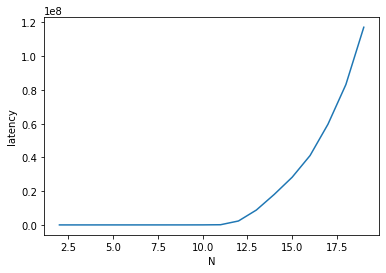

In [20]:
sb.lineplot(data=data[['N', 'latency']], x='N', y='latency', sort=True, ci=None)

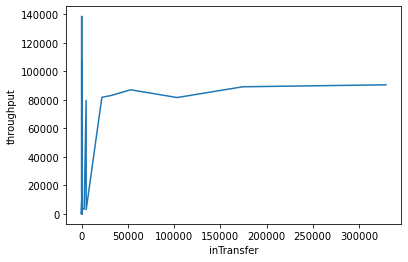

In [21]:
sb.lineplot(data=data[['inTransfer', 'throughput']], x='inTransfer', y='throughput', sort=True, ci=None)

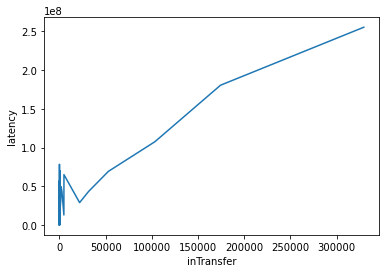

In [22]:
sb.lineplot(data=data[['inTransfer', 'latency']], x='inTransfer', y='latency', sort=True, ci=None)

In [23]:
from matplotlib.colors import LogNorm

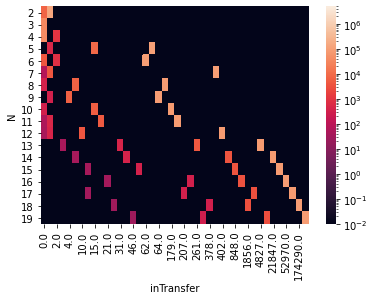

In [24]:
df = data[['N', 'inTransfer', 'throughput']].round().reset_index().pivot_table(index='N', columns='inTransfer', values='throughput').fillna(0.01)
sb.heatmap(df, norm=LogNorm(vmin=0.01, vmax=5e6), vmin=0.01, vmax=5e6)

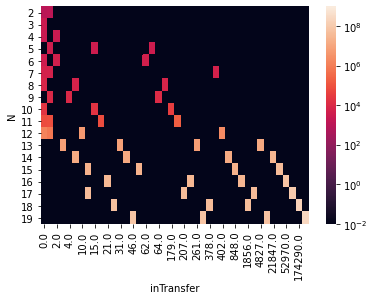

In [25]:
df = data[['N', 'inTransfer', 'latency']].round().reset_index().pivot_table(index='N', columns='inTransfer', values='latency').fillna(0.01)
sb.heatmap(df, norm=LogNorm(vmin=0.01, vmax=1e9), vmin=0.01, vmax=1e9)

### Выводы
Можно заметить, что характер рассматриваемых зависимостей, как и следовало ожидать, практически не изменился, однако в абсолютных показателях была достигнуто определенное улучшение результатов. SpscLinkedQueue практически не дает прироста производительности по целевым показателям, однако SpscLinkedAtomicQueue обеспечивает в полтора раза большую пропускную способность при большом количестве узлов и на 20% меньшую задержку при больших значениях inTransfer, поэтому далее будем использовать только ее. <br>
### Оптимизация протокола
Видно, что при большом количестве узлов в сети скапливается очень большое количество сообщений, ожидающих пересылки. Для решения этой проблемы введем следующую модификацию протокола: пусть теперь каждый узел не имеет права отправить новое сообщение, пока он не обработал все сообщения, лежащие в его входном буфере. Посмотрим на результаты работы модели после такой модификации:

In [26]:
data = pd.read_csv('benchmark_3.csv', header = 0, names = ['N', 'inTransfer', 'throughput', 'latency'])
data['throughput'] = data['throughput']/data['N']

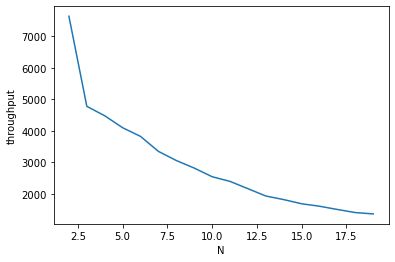

In [27]:
sb.lineplot(data=data[['N', 'throughput']], x='N', y='throughput', sort=True, ci=None)

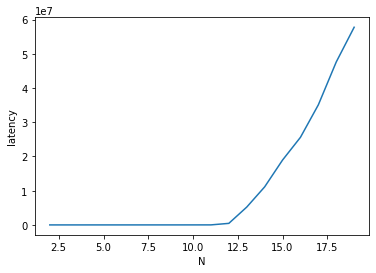

In [28]:
sb.lineplot(data=data[['N', 'latency']], x='N', y='latency', sort=True, ci=None)

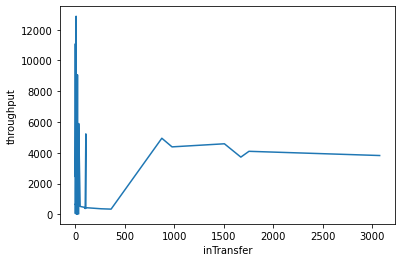

In [29]:
sb.lineplot(data=data[['inTransfer', 'throughput']], x='inTransfer', y='throughput', sort=True, ci=None)

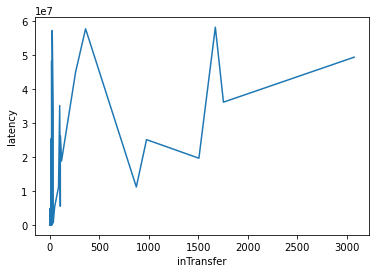

In [30]:
sb.lineplot(data=data[['inTransfer', 'latency']], x='inTransfer', y='latency', sort=True, ci=None)

In [31]:
from matplotlib.colors import LogNorm

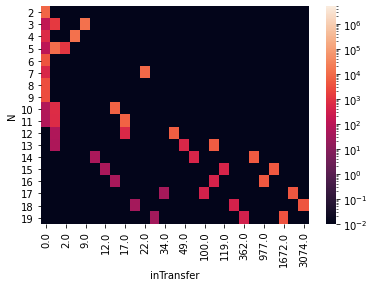

In [32]:
df = data[['N', 'inTransfer', 'throughput']].round().reset_index().pivot_table(index='N', columns='inTransfer', values='throughput').fillna(0.01)
sb.heatmap(df, norm=LogNorm(vmin=0.01, vmax=5e6), vmin=0.01, vmax=5e6)

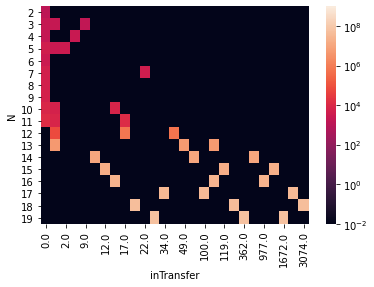

In [33]:
df = data[['N', 'inTransfer', 'latency']].round().reset_index().pivot_table(index='N', columns='inTransfer', values='latency').fillna(0.01)
sb.heatmap(df, norm=LogNorm(vmin=0.01, vmax=1e9), vmin=0.01, vmax=1e9)

### Вывод
Предложенная модификация протокола позволила примерно на два порядка сократить максимальное значение inTransfer, за счет чего было достигнуто уменьшение задержки при больших N примерно в 3 раза. Однако побочным эффектом стало значительное снижение пропускной способности: для большого числа потоков она упала до 2000, то есть примерно в 15 раз. С учетом этого можно сказать, что при реализации предложенного протокола необходимо иметь ввиду tradeoff между throughput и latency, отдавая предпочтение тому или иному в зависимости от конкретных требований. 

### Замечание
При очень большом количестве узлов работу данного протокола можно было бы значительно ускорить, модифицировав схему соединений между узлами. Если каждый узел $n$ соединять не только c $n+1$, но также с $n+2$, $n+4$, $n+8$ и тд (на практике имело бы смысл начинать с большей степени двойки в зависимости от параметров конкретных узлов), то потребовалось бы $n*log(n)$ соединений против $n$ в исходной схеме, однако для доставки каждого из пакетов потребовалось бы в среднем не $\frac{n}{2}$, а $log(\frac{n}{2})$ пересылок, что обеспечило бы значительный прирост производительности. Кроме того, старая схема крайне уязвима к отказу или просто низкой производительности каждого из узлов, в то время как с дополнительными соединениями критичность каждого из узлов падает, и дополнительно появляется возможность отправлять сообщения в обход проблемных узлов